In [122]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000

In [123]:
data_folders = ["90s_hiphop", "90s_rock", "2010s_pop", "classical", "country"]

# load trajectories
trajectories = dict()
for folder in data_folders:
    trajectories[folder] = np.load(f"data/{folder}_trajectories.npy", allow_pickle=True).item()

In [124]:
# Crazy Torch Model
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # First fully connected layer
      self.fc1 = nn.Linear(13 * 768, 768)
      
      # Get outputs
      self.fc2 = nn.Linear(768,5)
      
    def forward(self, x):
      outputs = F.relu(self.fc1(x))
      outputs = F.sigmoid(self.fc2(outputs))
      return outputs
    
model = Net()
model.load_state_dict(torch.load('models/model_50000.pt'))

<All keys matched successfully>

In [125]:
new_trajectories = dict()
endpoints = dict()

for folder in data_folders:
    new_trajectories[folder] = dict()
    endpoints[folder] = np.zeros((len(trajectories[folder]), 768))
    for i, song in tqdm(enumerate(trajectories[folder])):
        new_traj = model.fc1(torch.tensor(trajectories[folder][song]).flatten(start_dim=1).float()).detach().numpy()
        new_trajectories[folder][song] = (song, new_traj)
        endpoints[folder][i] = np.sum(new_traj, axis=0).reshape(-1)
# tests =  = [trajectories['90s_hiphop'][i] for i in trajectories['90s_hiphop'].keys()]

93it [00:00, 235.27it/s]
70it [00:00, 237.46it/s]
67it [00:00, 247.84it/s]
60it [00:00, 204.34it/s]
75it [00:00, 258.42it/s]


In [126]:
labels = np.zeros((365, 1))
start = 0
for idx, folder in enumerate(data_folders):
    n = len(endpoints[folder])
    print(f"{folder}: {n} songs")
    labels[start:start+len(endpoints[folder]), :] = idx
    start = start + len(endpoints[folder])

90s_hiphop: 93 songs
90s_rock: 70 songs
2010s_pop: 67 songs
classical: 60 songs
country: 75 songs


In [127]:
from sklearn.cluster import KMeans
X = np.concatenate([endpoints[folder] for folder in data_folders])
preds = KMeans(n_clusters=5, random_state=0).fit_predict(X)

In [129]:
for cluster in range(5):
    unique, counts = np.unique(labels[preds == cluster], return_counts=True)
    print(dict(zip(unique, counts)))

"""

0: {1.0: 1, 2.0: 62, 4.0: 2}    # 90s rock
1: {3.0: 21}                    # classical
2: {1.0: 68, 2.0: 5, 4.0: 73}   
3: {0.0: 93, 1.0: 1}
4: {3.0: 39}

"""


{1.0: 1, 2.0: 62, 4.0: 2}
{3.0: 21}
{1.0: 68, 2.0: 5, 4.0: 73}
{0.0: 93, 1.0: 1}
{3.0: 39}


In [131]:
from sklearn.decomposition import PCA

all_features = np.concatenate([new_trajectories[folder][song][1] for folder in data_folders for song in new_trajectories[folder]])
pca = PCA(n_components=2).fit(all_features)

In [132]:
pca_endpoints = dict()

for folder in data_folders:
    pca_endpoints[folder] = np.zeros((len(trajectories[folder]), 2))
    for i, song in tqdm(enumerate(trajectories[folder])):
        new_traj = new_trajectories[folder][song][1]
        pca_endpoints[folder][i] = np.sum(pca.transform(new_traj), axis=0)
# tests =  = [trajectories['90s_hiphop'][i] for i in trajectories['90s_hiphop'].keys()]

93it [00:00, 10681.00it/s]
70it [00:00, 10138.17it/s]
67it [00:00, 10572.55it/s]
60it [00:00, 9693.70it/s]
75it [00:00, 10971.05it/s]


In [133]:
pca_datapoints = np.concatenate([pca_endpoints[folder] for folder in data_folders])
pca_labels = KMeans(n_clusters=5, random_state=0).fit_predict(X)

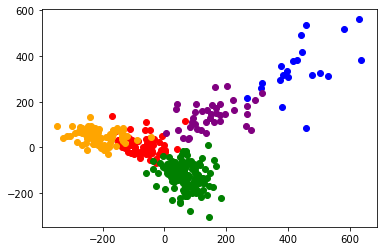

In [134]:
plt.plot(pca_datapoints[pca_labels == 0, 0], pca_datapoints[pca_labels == 0, 1], 'o', color='red')
plt.plot(pca_datapoints[pca_labels == 1, 0], pca_datapoints[pca_labels == 1, 1], 'o', color='blue')
plt.plot(pca_datapoints[pca_labels == 2, 0], pca_datapoints[pca_labels == 2, 1], 'o', color='green')
plt.plot(pca_datapoints[pca_labels == 3, 0], pca_datapoints[pca_labels == 3, 1], 'o', color='orange')
plt.plot(pca_datapoints[pca_labels == 4, 0], pca_datapoints[pca_labels == 4, 1], 'o', color='purple')
plt.show()

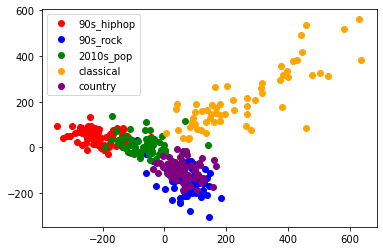

In [149]:
labels = np.array(labels, dtype=int).flatten()
                  
plt.plot(pca_datapoints[labels == 0.0, 0], pca_datapoints[labels == 0.0, 1], 'o', color='red', label=data_folders[0])
plt.plot(pca_datapoints[labels == 1.0, 0], pca_datapoints[labels == 1.0, 1], 'o', color='blue', label=data_folders[1])
plt.plot(pca_datapoints[labels == 2.0, 0], pca_datapoints[labels == 2.0, 1], 'o', color='green', label=data_folders[2])
plt.plot(pca_datapoints[labels == 3.0, 0], pca_datapoints[labels == 3.0, 1], 'o', color='orange', label=data_folders[3])
plt.plot(pca_datapoints[labels == 4.0, 0], pca_datapoints[labels == 4.0, 1], 'o', color='purple', label=data_folders[4])
plt.legend()
plt.show()

0.0